In [31]:
import numpy as np
import tensorflow as tf
import mlflow
import mlflow.tensorflow
import os
from PIL import Image, ImageDraw
import random
import matplotlib.pyplot as plt
import cv2
import glob
import imgaug.augmenters as iaa
import imgaug as ia
import datetime
import time

import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Dropout, Flatten, Dense, Conv2DTranspose, UpSampling2D, Concatenate, Reshape  )
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")


#### Move images to one folder

In [32]:
def imshow(img: np.array):
    if img.shape[0] * 2 > img.shape[1]:
        fig = plt.figure(figsize=(7, 7))
    else:
        fig = plt.figure(figsize=(20, 20))
    plt.axis('off')
    plt.imshow(img)

In [33]:
# import os
# import shutil

# def move_images_to_one_folder(source_folder, target_folder, image_extensions=['.jpg', '.jpeg', '.png', '.bmp']):
#     # Create target folder if it doesn't exist
#     if not os.path.exists(target_folder):
#         os.makedirs(target_folder)

#     # Walk through the source folder and subfolders
#     for root, dirs, files in os.walk(source_folder):
#         for file in files:
#             # Check if the file is an image based on the extensions
#             if any(file.lower().endswith(ext) for ext in image_extensions):
#                 # Define the full file path
#                 source_file = os.path.join(root, file)
#                 target_file = os.path.join(target_folder, file)
                
#                 # Handle duplicate filenames by appending a number
#                 counter = 1
#                 while os.path.exists(target_file):
#                     name, ext = os.path.splitext(file)
#                     target_file = os.path.join(target_folder, f"{name}_{counter}{ext}")
#                     counter += 1
                
#                 # Move the file
#                 shutil.move(source_file, target_file)
#                 print(f"Moved {file} to {target_folder}")

# # Example usage
# source_folder = "M:/CUDA/CV-ImageInpainting/CV-ImageInpainting/Data/VegetableImages/validation"
# target_folder = "M:/CUDA/CV-ImageInpainting/CV-ImageInpainting/Data/VegetableImages/all_images"
# move_images_to_one_folder(source_folder, target_folder)


### Rename images to 0,1,2,3

In [34]:
# import os

# def rename_images_in_folder(folder_path):
#     # Get all files in the folder
#     files = os.listdir(folder_path)

#     # Filter out non-image files if needed, based on file extension
#     image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
#     image_files = [f for f in files if any(f.lower().endswith(ext) for ext in image_extensions)]

#     # Rename files to 0.jpg, 1.jpg, 2.jpg, ..., but avoid overwriting
#     for idx, filename in enumerate(image_files):
#         old_file_path = os.path.join(folder_path, filename)
#         new_file_name = f"{idx}.jpg"
#         new_file_path = os.path.join(folder_path, new_file_name)
        
#         # Skip if the new file name already exists, increment index
#         while os.path.exists(new_file_path):
#             idx += 1
#             new_file_name = f"{idx}.jpg"
#             new_file_path = os.path.join(folder_path, new_file_name)

#         # Rename the file
#         os.rename(old_file_path, new_file_path)
#        # print(f"Renamed {filename} to {new_file_name}")

# # Example usage
# folder_path = "./Data/VegetableImages/all_images"
# rename_images_in_folder(folder_path)


### make X dataset by drawing boxes

In [35]:
def add_center_black_square(image_path, output_path, max_percentage=10):
    """
    Add a single black square at the center of the image.
    
    Args:
        image_path (str): Path to the input image.
        output_path (str): Path to save the output image.
        max_percentage (float): Maximum percentage of the image area covered by the square.
    """
    # Open the image
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    width, height = image.size
    max_area = (width * height) * (max_percentage / 100)  # Maximum area of the square

    # Determine the square's side length (making it square-shaped)
    side_length = int(max_area ** 0.5)

    # Calculate the position to center the square
    x0 = (width - side_length) // 2
    y0 = (height - side_length) // 2
    x1 = x0 + side_length
    y1 = y0 + side_length

    # Draw the black square at the center
    draw.rectangle([x0, y0, x1, y1], fill=(0, 0, 0))

    # Save the output image
    image.save(output_path)

In [36]:
def process_vegetable_images(input_folder, output_folder, max_percentage=10, num_squares=1):
    """
    Process all images in the 'test' folder structure in VegetableImages and add black squares.

    - input_folder: Path to the input folder containing subfolders of vegetables.
    - output_folder: Path to save the processed images.
    - max_percentage: Maximum percentage of the image area covered by each square.
    - num_squares: Number of black squares to add.
    """
    # image_counter = 0
    for root, dirs, files in os.walk(input_folder):
        # Recreate the folder structure in the output folder
        relative_path = os.path.relpath(root, input_folder) # Relative path to the input folder
        save_path = os.path.join(output_folder, relative_path) # Path to save the output images
        os.makedirs(save_path, exist_ok=True) # Create the folder if it does not exist

        for file in files:  # Process all files in the folder
            if file.lower().endswith(('png', 'jpg', 'jpeg')): # Check if the file is an image
                input_path = os.path.join(root, file) # Path to the input image
                output_path = os.path.join(save_path, file) # Path to save the output image
                # add_black_squares_to_image(input_path, output_path, max_percentage, num_squares) # Add black squares
                add_center_black_square(input_path, output_path, max_percentage) # Add a single black square at the center
                # print(f"Processed: {input_path} -> {output_path}") # Print the processed image path
                # image_counter += 1

In [37]:
train_folder = "./Data/VegetableImages/all_images"
output_folder = "./Data/VegetableImages/all_holes"
# Process the images
process_vegetable_images(train_folder, output_folder, max_percentage=10, num_squares=3)

***

In [38]:
x_set = []
for idx, file in enumerate(glob.glob("./Data/VegetableImages/all_images/*")):
    x_set.append(np.array(Image.open(file).resize((192,192))))
x_set = np.array(x_set)
x_set.shape
y_set = []
for idx, file in enumerate(glob.glob("./Data/VegetableImages/all_holes/*")):
    y_set.append(np.array(Image.open(file).resize((192,192))))
y_set = np.array(y_set)
y_set.shape

(1400, 192, 192, 3)

### Original images and images to inpaint

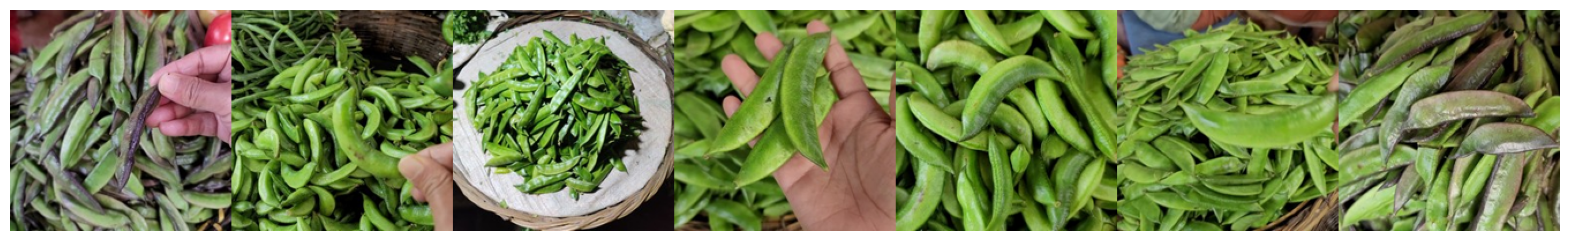

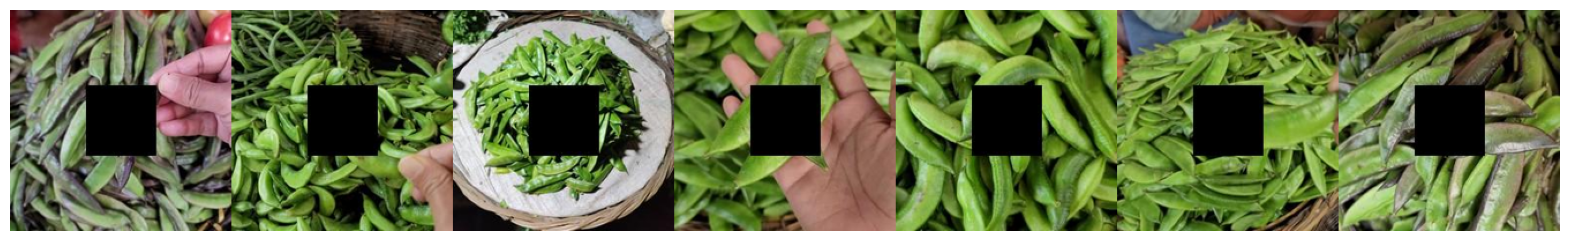

In [39]:
ids = np.random.choice(len(y_set), 7)
imshow(np.concatenate(x_set[ids], 1))
imshow(np.concatenate(y_set[ids], 1))

In [40]:
class DataGenerator(keras.utils.Sequence):
    def __init__(
        self, X, y, batch_size=64, dim=(192, 192), n_channels=3, augment_prob=0.2
    ):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.augment_prob = augment_prob

        #DATA AUGUMENTATION WITH KERAS
        self.datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            brightness_range=(0.8, 1.2),
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode="nearest",
        )

        self.on_epoch_end()
        assert len(self.X) == len(self.y) or len(self.X) > 0

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        return self.__data_generation(indexes)

    def __len__(self):
        return int(np.floor(len(self.X) / self.batch_size))

    def __data_generation(self, ids):
        X_batch = np.empty(
            (self.batch_size, self.dim[0], self.dim[1], self.n_channels),
            dtype="float32",
        )
        y_batch = np.empty(
            (self.batch_size, self.dim[0], self.dim[1], self.n_channels),
            dtype="float32",
        )

        for i, idx in enumerate(ids):
            # Load image and mask
            image = np.array(Image.open(self.X[idx]).resize(self.dim))
            label = np.array(Image.open(self.y[idx]).resize(self.dim))

            if np.random.rand() < self.augment_prob:
                # Apply augmentation to the image and normalize
                augmented = self.datagen.random_transform(image)
                X_batch[i,] = self.normalize(augmented)
            else:
                # Normalize directly
                X_batch[i,] = self.normalize(image)
        
            y_batch[i,] = self.normalize(label)

        return X_batch, y_batch
    
    def normalize(self, image):
        image = image / 255.0  # Convert to range [0, 1]
        return (image - 0.5) / 0.5  # Scale to [-1, 1] for GAN to work the best 

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.X))

In [41]:
X_files = sorted(glob.glob("./Data/VegetableImages/all_images/*.jpg"))
y_files = sorted(glob.glob("./Data/VegetableImages/all_holes/*.jpg"))

X_train, X_test, y_train, y_test = train_test_split(X_files, y_files, test_size=0.2, random_state=42)
train_generator = DataGenerator(X_train, y_train)
test_generator = DataGenerator(X_test, y_test)

In [42]:
print(f"Train: {np.array(X_train).shape}")
print(f"Test:  {np.array(X_test).shape}")


Train: (1120,)
Test:  (280,)


***
# Metrics

In [43]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    epsilon = keras.backend.epsilon()
    return (2. * intersection + epsilon) / (keras.backend.sum(y_true_f + y_pred_f) + epsilon)

In [44]:
def jaccard_distance(y_true, y_pred, smooth=100):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [45]:
def cosine_similarity(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    return K.sum(y_pred * y_true) / tf.norm(y_pred) / tf.norm(y_true)

***
# Losses

In [46]:
MAE_loss = tf.keras.losses.MeanAbsoluteError()

In [47]:
def SSIM_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [48]:
def PSNR_loss(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

***

# GAN


In [49]:
class Discriminator(keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
    
    def __conv_block(self, out, kernel_size, dropout_rate, prev_layer):
        x = Conv2D(out, kernel_size, padding="same")(prev_layer)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Dropout(dropout_rate)(x)
        return x
    
    def model(self, input_shape=(192,192, 3), dropout_rate=0.1, kernel_size=(3, 3)):
        inputs = keras.layers.Input(input_shape)

        x1 = self.__conv_block(16, kernel_size, dropout_rate, inputs)
        x2 = self.__conv_block(32, kernel_size, dropout_rate, x1)
        x3 = self.__conv_block(64, kernel_size, dropout_rate, x2)
        x4 = self.__conv_block(128, kernel_size, dropout_rate, x3)
        x5 = self.__conv_block(256, kernel_size, dropout_rate, x4)

        outputs = Flatten()(x5)
        outputs = Dense(1, activation = 'sigmoid')(outputs)

        return Model(inputs=[inputs], outputs=[outputs])

In [50]:
class AutoencoderWithSkipConnections(keras.Model):
    def __init__(self):
        super(AutoencoderWithSkipConnections, self).__init__()

    def __ConvBlock(self, filters, kernel_size, dropout_rate, prev_layer):
        conv = Conv2D(filters, kernel_size, activation='relu', padding='same')(prev_layer)
        conv = BatchNormalization()(conv)
        conv = Dropout(dropout_rate)(conv)
        return conv

    def __MaxPoolBlock(self, prev_layer):
        pool = MaxPooling2D(pool_size=(2, 2))(prev_layer)
        return pool

    def __UpsampleBlock(self, prev_layer, skip_connection, filters, kernel_size):
        upsample = UpSampling2D((2, 2))(prev_layer)
        upsample = Concatenate(axis=-1)([upsample, skip_connection])
        conv = Conv2D(filters, kernel_size, activation='relu', padding='same')(upsample)
        conv = BatchNormalization()(conv)
        return conv

    def model(self, input_shape=(192, 192, 3), dropout_rate=0.1, kernel_size=(3, 3)):
        inputs = Input(input_shape)

        # Encoder
        conv1 = self.__ConvBlock(128, kernel_size, dropout_rate, inputs)
        pool1 = self.__MaxPoolBlock(conv1)

        conv2 = self.__ConvBlock(64, kernel_size, dropout_rate, pool1)
        pool2 = self.__MaxPoolBlock(conv2)

        conv3 = self.__ConvBlock(32, kernel_size, dropout_rate, pool2)
        pool3 = self.__MaxPoolBlock(conv3)

        conv4 = self.__ConvBlock(16, kernel_size, dropout_rate, pool3)
        pool4 = self.__MaxPoolBlock(conv4)

        conv5 = self.__ConvBlock(8, kernel_size, dropout_rate, pool4)

        # Get the shape of conv5 for reshaping in the decoder
        shape = K.int_shape(conv5)

        # Bottleneck layer
        flatten = Flatten()(conv5)
        dense1 = Dense(32, activation='relu', name='bottleneck')(flatten)
        dense1 = Dropout(dropout_rate)(dense1)
        dense2 = Dense(shape[1] * shape[2] * shape[3], activation='relu')(dense1)
        dense2 = Dropout(dropout_rate)(dense2)
        dense2 = Reshape((shape[1], shape[2], shape[3]))(dense2)

        # Decoder
        upx = Concatenate(axis=-1)([dense2, conv5])
        convx = self.__ConvBlock(8, kernel_size, dropout_rate, upx)

        conv9 = self.__UpsampleBlock(convx, conv4, 16, kernel_size)
        conv10 = self.__UpsampleBlock(conv9, conv3, 32, kernel_size)

        conv11 = UpSampling2D((2, 2))(conv10)
        conv11 = Conv2D(64, kernel_size, activation='relu', padding='same')(conv11)

        conv12 = UpSampling2D((2, 2))(conv11)
        conv12 = Concatenate(axis=-1)([conv12, conv1])
        conv13 = Conv2D(128, kernel_size, activation='relu', padding='same')(conv12)
        conv13 = BatchNormalization()(conv13)

        # Output layer
        decoded_outputs = Conv2D(3, kernel_size, activation='sigmoid', padding='same', name='decoder')(conv13)

        model = Model(inputs=[inputs], outputs=[decoded_outputs])
        model.summary()

        return model


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 192, 192, 3)]        0         []                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 192, 192, 128)        3584      ['input_4[0][0]']             
                                                                                                  
 batch_normalization_19 (Ba  (None, 192, 192, 128)        512       ['conv2d_20[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 dropout_18 (Dropout)        (None, 192, 192, 128)        0         ['batch_normalization_19

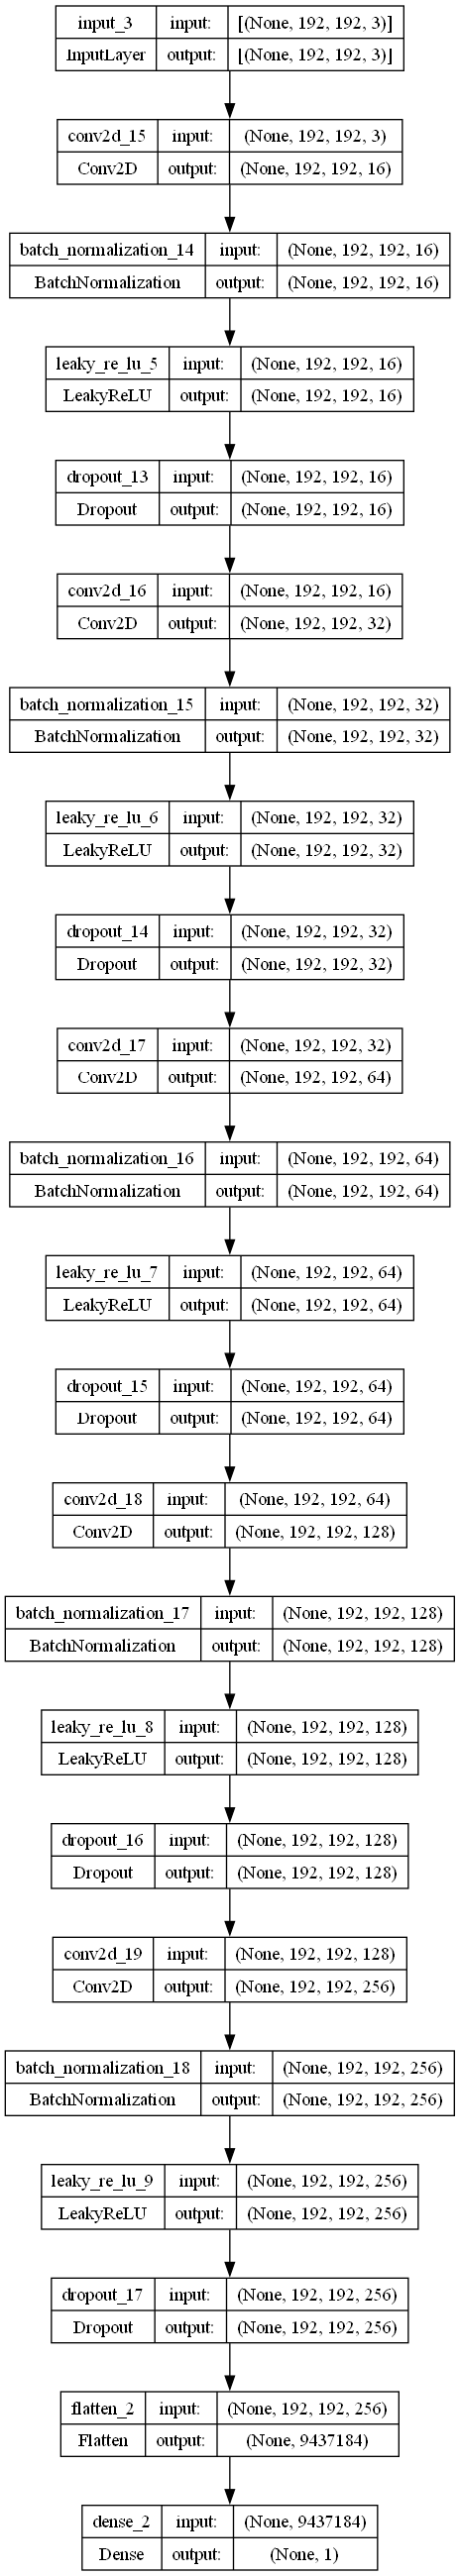

In [51]:
discriminator = Discriminator().model(input_shape=(192,192, 3), dropout_rate=0.3)
generator = AutoencoderWithSkipConnections().model(input_shape=(192,192, 3))

#plotting the architecture
keras.utils.plot_model(generator, show_shapes=True, to_file='./generator.png')
keras.utils.plot_model(discriminator, show_shapes=True, to_file='./discriminator.png')


In [52]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=False)

def compute_generator_loss(y_real, y_gen, fake_output):
    l1_loss = tf.reduce_mean(tf.abs(y_gen - y_real))
    gan_loss = cross_entropy(tf.ones_like(fake_output, dtype= 'float32'), fake_output)
    return l1_loss + 3 * gan_loss


def compute_discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output, dtype= 'float32') * np.random.uniform(low = 0.9, high = 1), real_output)
    gen_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    return 0.5 * (real_loss + gen_loss)


generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

In [53]:
def start_mlflow_run():
    mlflow.end_run()
    mlflow.start_run()


def log_losses(epoch):
    mlflow.log_metric("generator_loss", g_loss.result(), step=epoch)
    mlflow.log_metric("discriminator_loss", d_loss.result(), step=epoch)
    mlflow.log_metric("cosine_similarity", similarity.result(), step=epoch)


def log_validation_loss(val_gen_loss, epoch):
    mlflow.log_metric("val_generator_loss", val_gen_loss, step=epoch)

In [54]:
NUM_EPOCHS = 4000

d_loss = tf.keras.metrics.Mean(name='discriminator_loss')
g_loss = tf.keras.metrics.Mean(name='generator_loss')
similarity = tf.keras.metrics.Mean(name='cosine_similarity')

@tf.function
def perform_train_step(input_images, target_images):
    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        generated_images = generator(input_images, training=True)

        real_output = discriminator(target_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss_value = compute_generator_loss(target_images, generated_images, fake_output)
        disc_loss_value = compute_discriminator_loss(real_output, fake_output)

    # Compute gradients
    generator_gradients = generator_tape.gradient(gen_loss_value, generator.trainable_variables)
    discriminator_gradients = discriminator_tape.gradient(disc_loss_value, discriminator.trainable_variables)

    # Apply gradients
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    
    # Update metrics
    g_loss(gen_loss_value)
    d_loss(disc_loss_value)
    similarity(tf.reduce_mean(cosine_similarity(target_images, generated_images)))


def train(training_generator, validation_generator, num_epochs):
    start_mlflow_run()
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        # Train on batches from the training generator
        for batch_input, batch_target in training_generator:
            perform_train_step(batch_input, batch_target)

        # Display epoch time and losses
        print(f'Epoch {epoch + 1} completed in {time.time() - epoch_start_time:.2f} seconds')
        print(f'Generator Loss: {g_loss.result()}, Discriminator Loss: {d_loss.result()}\n')
        
        log_losses(epoch)
        
        # Validation phase
        val_generated_images = generator(validation_generator[0][0], training=False)
        val_fake_output = discriminator(val_generated_images, training=False)
        val_generator_loss = compute_generator_loss(validation_generator[0][1], val_generated_images, val_fake_output)
        
        log_validation_loss(val_generator_loss, epoch)
        
        d_loss.reset_states()
        g_loss.reset_states()
        similarity.reset_states()
        
    mlflow.tensorflow.log_model(generator, "generator_model")
    mlflow.tensorflow.log_model(discriminator, "discriminator_model")
    
    mlflow.end_run()



In [ ]:
train(train_generator, test_generator, NUM_EPOCHS)

In [ ]:
generator.save('./models/gan/generator/')
discriminator.save('./models/gan/discriminator/')